In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [2]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

In [3]:
!chmod -600 "/content/kaggle.json"

In [4]:
!kaggle datasets download -d adityajn105/flickr8k

^C


In [5]:
zip_ref = zipfile.ZipFile("/content/flickr8k.zip")
zip_ref.extractall()
zip_ref.close()

# **image Preprocess**

In [2]:
images_path = '/content/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [3]:
images[:5]

['/content/Images/247691240_3881777ab8.jpg',
 '/content/Images/2561319255_ce5ede291e.jpg',
 '/content/Images/3244470342_c08f6bb17e.jpg',
 '/content/Images/2855417531_521bf47b50.jpg',
 '/content/Images/3638577494_fe55f7b4cb.jpg']

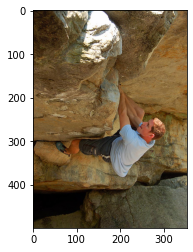

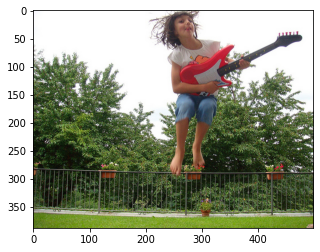

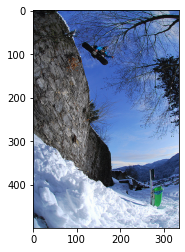

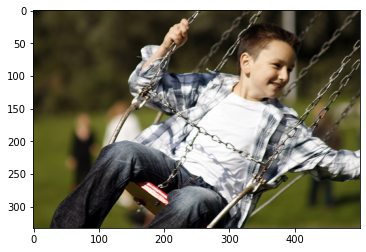

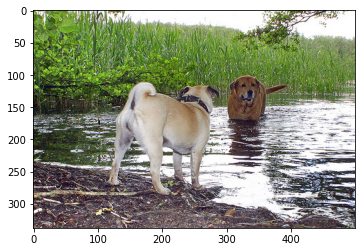

In [4]:
# import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [5]:
incept_model = ResNet50(include_top=True)

In [6]:

last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
modele.save("restnet50Model.h5")

In [8]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count +=1
    
    if count > 2000:
        break
        
    elif count % 1000 == 0:
        print(count)

1000
2000


In [9]:
len(images_features)

2001

# **Text Preprocess**

In [10]:
caption_path = '/content/captions.txt'

In [11]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [12]:
len(captions)

40457

In [13]:
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [14]:
captions[1:10]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .']

In [15]:
captions_dict = {}

for i in captions[1:]:
    try:
        img_name = i.split(',')[0]
        caption = i.split(',')[1]
        # print(img_name)
        # print(caption)
        if img_name not in captions_dict:
            captions_dict[img_name] = [caption]  
        else:
            captions_dict[img_name].append(caption)     
    except:
        pass

In [16]:
len(captions_dict)

8091

In [17]:
captions_dict["1001773457_577c3a7d70.jpg"]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

# **Visualize Images with captions**

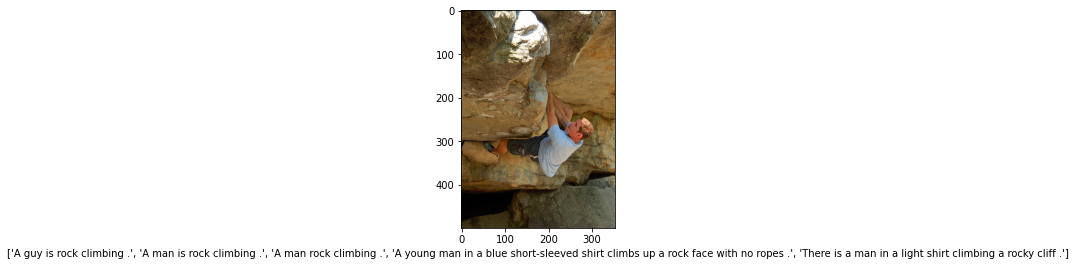

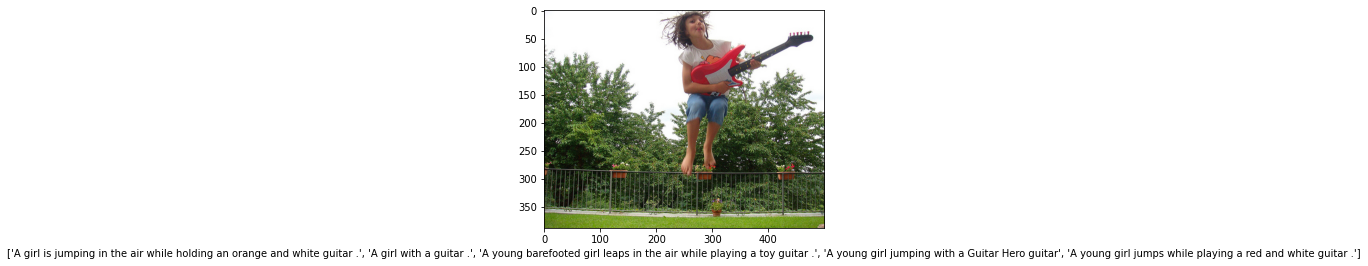

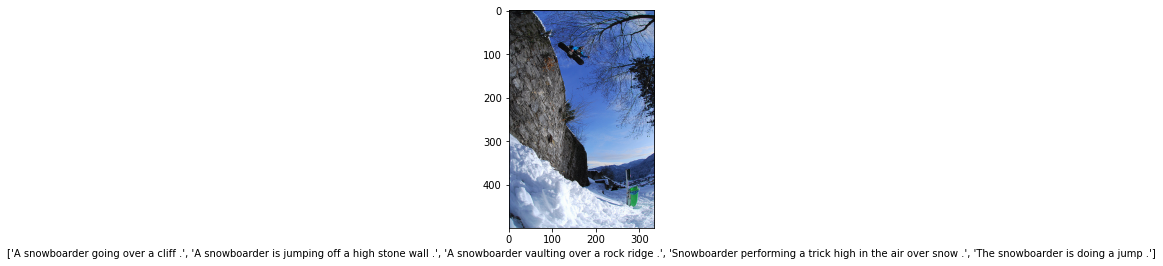

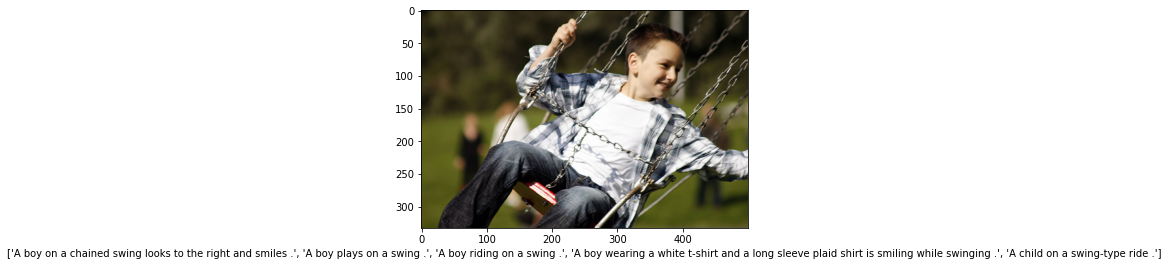

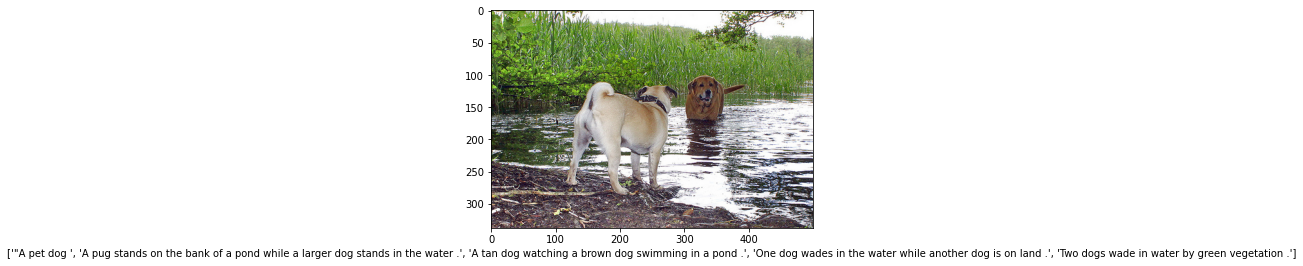

In [18]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

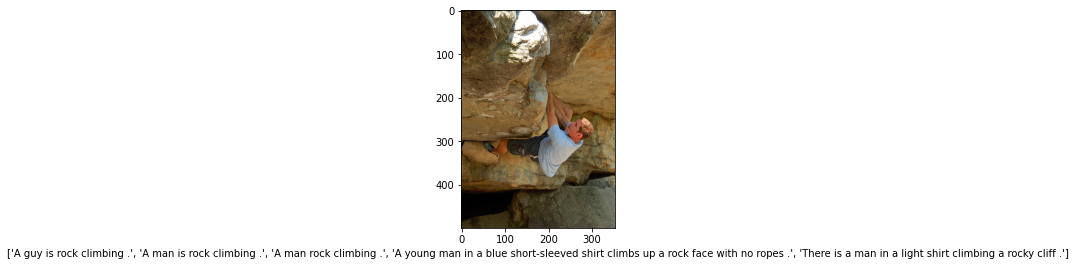

In [19]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '/content/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [20]:

def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified
    

In [21]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

# **Create Vocabulary**

In [22]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [23]:
len(count_words)

8873

In [24]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [25]:
len(new_dict)

8873

In [26]:
new_dict['<OUT>'] = len(new_dict) 

In [27]:
captions_backup = captions_dict.copy()

In [28]:
captions_dict = captions_backup.copy()

In [29]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [30]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1001773457_577c3a7d70.jpg': [[1, 2, 29, 30, 31, 2, 32, 30, 33, 34, 17],
  [1, 2, 29, 30, 31, 2, 35, 30, 36, 37, 38, 39, 40, 25, 41, 16, 17],
  [1,
   2,
   29,
   30,
   31,
   2,
   42,
   30,
   37,
   43,
   44,
   33,
   45,
   46,
   38,
   39,
   4,
   25,
   47,
   16,
   17],
  [1, 48, 49, 11, 50, 51, 52, 46, 38, 39, 40, 25, 41, 16, 17],
  [1, 48, 49, 40, 53, 54, 55, 38, 39, 16, 17]],
 '1002674143_1b742ab4b8.jpg': [[1,
   2,
   23,
   18,
   56,
   4,
   57,
   58,
   4,
   59,
   11,
   2,
   60,
   61,
   37,
   27,
   62,
   4,
   2,
   63,
   16,
   17],
  [1, 2, 23, 18, 7, 64, 4, 59, 11, 2, 65, 60, 61, 16, 17],
  [1,
   2,
   6

------------------------------------------------------------------------------------------------------

# **Build Generator Function**

In [31]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 2, 10, 11, 12, 4, 13, 14, 15, 16, 17]
[1, 2, 29, 30, 31, 2, 42, 30, 37, 43, 44, 33, 45, 46, 38, 39, 4, 25, 47, 16, 17]
[1, 2, 23, 18, 56, 4, 57, 58, 4, 59, 11, 2, 60, 61, 37, 27, 62, 4, 2, 63, 16, 17]
[1, 2, 66, 18, 4, 25, 67, 68, 37, 69, 4, 59, 11, 2, 42, 70, 37, 2, 61, 40, 71, 16, 17]
[1, 2, 77, 7, 93, 25, 246, 11, 2, 236, 9, 26, 81, 225, 4, 59, 11, 398, 338, 80, 186, 77, 190, 40, 16, 17]
[1, 2, 77, 4, 142, 563, 2, 23, 147, 9, 4, 25, 229, 31, 587, 193, 83, 26, 588, 387, 589, 294, 106, 218, 83, 16, 17]
[1, 25, 18, 4, 25, 650, 584, 651, 7, 143, 88, 26, 48, 75, 198, 652, 145, 7, 103, 2, 29, 653, 31, 25, 39, 7, 654, 655, 16, 17]
[1, 2, 77, 4, 2, 29, 162, 31, 164, 295, 947, 2, 236, 4, 29, 289, 31, 2, 1128, 162, 4, 59, 11, 2, 1127, 351, 37, 950, 156, 221, 16, 17]
[1, 2, 18, 4, 2, 112, 31, 29, 1460, 37, 42, 1239, 7, 143, 88, 26, 2, 77, 4, 2, 883, 31, 2, 18, 4, 2, 544, 5, 31, 29, 31, 42, 1461, 653, 16, 17]


In [33]:
MAX_LEN

36

In [34]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1001773457_577c3a7d70.jpg': [[1, 2, 29, 30, 31, 2, 32, 30, 33, 34, 17],
  [1, 2, 29, 30, 31, 2, 35, 30, 36, 37, 38, 39, 40, 25, 41, 16, 17],
  [1,
   2,
   29,
   30,
   31,
   2,
   42,
   30,
   37,
   43,
   44,
   33,
   45,
   46,
   38,
   39,
   4,
   25,
   47,
   16,
   17],
  [1, 48, 49, 11, 50, 51, 52, 46, 38, 39, 40, 25, 41, 16, 17],
  [1, 48, 49, 40, 53, 54, 55, 38, 39, 16, 17]],
 '1002674143_1b742ab4b8.jpg': [[1,
   2,
   23,
   18,
   56,
   4,
   57,
   58,
   4,
   59,
   11,
   2,
   60,
   61,
   37,
   27,
   62,
   4,
   2,
   63,
   16,
   17],
  [1, 2, 23, 18, 7, 64, 4, 59, 11, 2, 65, 60, 61, 16, 17],
  [1,
   2,
   6

In [35]:
Batch_size = 128
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
      if k in photo:
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
        else:
          continue
            
    return X, y_in, y_out

In [36]:
X, y_in, y_out = generator(images_features, captions_dict)

In [37]:
len(X), len(y_in), len(y_out)

(121714, 121714, 121714)

In [38]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')



In [39]:
X.shape, y_in.shape, y_out.shape

((121714, 2048), (121714, 36), (121714, 8874))

In [40]:
X[1510]

array([0.7413473 , 0.02947531, 0.14117217, ..., 2.121067  , 1.0367655 ,
       0.15650305], dtype=float32)

In [41]:
y_in[1515]

array([  1.,   2., 758., 759., 125.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.])

# **MODEL**

In [42]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model

In [43]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 36, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 128)           1135872   
                                                                 
 lstm (LSTM)                 (None, 36, 256)           394240    
                            

In [59]:
model.fit([X, y_in], y_out, batch_size=128, epochs=10)

Epoch 1/10
951/951 [==============================] - 28s 30ms/step - loss: 0.6045 - accuracy: 0.8171
Epoch 2/10
951/951 [==============================] - 28s 30ms/step - loss: 0.6095 - accuracy: 0.8155
Epoch 3/10
951/951 [==============================] - 29s 30ms/step - loss: 0.6034 - accuracy: 0.8161
Epoch 4/10
951/951 [==============================] - 29s 30ms/step - loss: 0.5957 - accuracy: 0.8180
Epoch 5/10
951/951 [==============================] - 28s 30ms/step - loss: 0.5964 - accuracy: 0.8183
Epoch 6/10
951/951 [==============================] - 28s 30ms/step - loss: 0.6011 - accuracy: 0.8181
Epoch 7/10
951/951 [==============================] - 28s 30ms/step - loss: 0.5924 - accuracy: 0.8198
Epoch 8/10
951/951 [==============================] - 28s 30ms/step - loss: 0.5993 - accuracy: 0.8178
Epoch 9/10
951/951 [==============================] - 28s 30ms/step - loss: 0.5938 - accuracy: 0.8207
Epoch 10/10
951/951 [==============================] - 28s 30ms/step - loss: 0.586

In [60]:
inv_dict = {v:k for k, v in new_dict.items()}

In [61]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

# **Predictions**

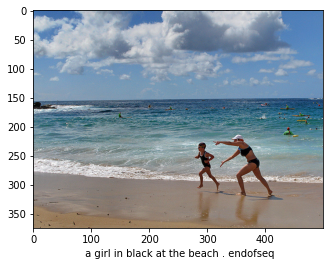

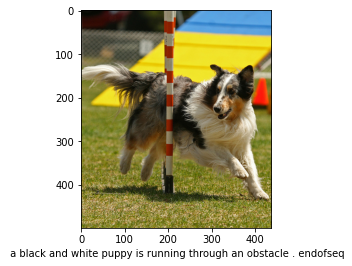

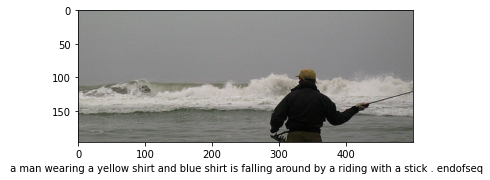

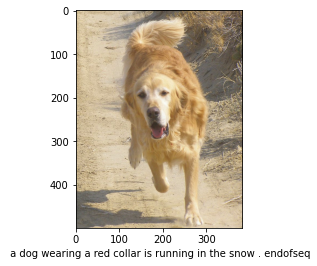

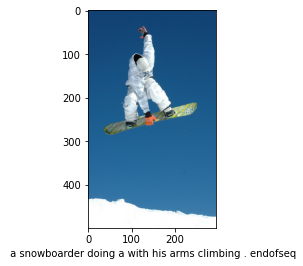

In [71]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 30:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

# Saving
 

In [68]:
model.save('model.h5')

In [69]:
model.save_weights('mine_model_weights.h5')

In [70]:
np.save('vocab.npy', new_dict)